In [1]:
import os, random, math, importlib
import model
importlib.reload(model)

import numpy as np
import torch
from torch import nn, optim

from torchinfo import summary

In [2]:
#Training config
cut_5 = False
hide = False


In [3]:
#Load data
f = open("res/dataset.csv")
raw = f.readlines()
f.close()
#Stores a tuple, containing (TIC, Class, Data, Train/Test)
stars = list()
train_test_ratio = 0.8
for line in raw:
    line = [int(s.strip()) for s in line.split()]
    data = np.load(os.path.expanduser("~/.lightkurve-cache/mastDownload/TESS_processed/") + str(line[0]) + ".npy")
    #if len(data[0] == 9):
    rn = random.random() < train_test_ratio
    stars.append((line[0], line[1], data[:, 1:-1, 1:-1], rn))#Middle
    if cut_5:
        stars.append((line[0], line[1], data[:, 2:, 1:-1], rn))#-x
        stars.append((line[0], line[1], data[:, :-2, 1:-1], rn))#+x
        stars.append((line[0], line[1], data[:, 1:-1, 2:], rn))#-y
        stars.append((line[0], line[1], data[:, 1:-1, :-2], rn))#+y

#Load fake data
f = open("res/dataset_sim.csv")
raw = f.readlines()
f.close()
#Stores a tuple, containing (TIC, Class, Data, Train/Test)
for line in raw:
    line = [int(float(s.strip())) for s in line.split()]
    data = np.load(os.path.expanduser("~/.lightkurve-cache/mastDownload/TESS_processed/") + str(line[0]) + ".npy")
    stars.append((line[0], line[1], data[:, 1:-1, 1:-1], True))#Middle
    if cut_5:
        stars.append((line[0], line[1], data[:, 2:, 1:-1], True))#-x
        stars.append((line[0], line[1], data[:, :-2, 1:-1], True))#+x
        stars.append((line[0], line[1], data[:, 1:-1, 2:], True))#-y
        stars.append((line[0], line[1], data[:, 1:-1, :-2], True))#+y

test_set = [star for star in stars if not star[3]]
train_set = [star for star in stars if star[3]]

In [4]:
print(len([star for star in stars if star[1]]), len([star for star in stars if not star[1]]), len(stars))
print(len(test_set), len(train_set), len(stars))

1738 1543 3281
251 3030 3281


In [5]:
#Hyperparameters
learning_rate = 0.00005
epochs = 250
batch_size = 48
flip_chance = 0.5

#Create model
classifier = model.TESSClassifier_5()


#Check for GPU
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    classifier.to(device)

#Loss and optimizer
loss = nn.CrossEntropyLoss()
opt = optim.Adam(classifier.parameters(), lr = learning_rate)

print(summary(classifier, input_size=(batch_size, 1, 2000, 7, 7), col_names = ("input_size", "output_size", "num_params", "mult_adds")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
TESSClassifier_5                         --                        --                        --                        --
├─Sequential: 1-1                        [48, 1, 2000, 7, 7]       [48, 8, 3, 2, 2]          --                        --
│    └─Sequential: 2-1                   [48, 1, 2000, 7, 7]       [48, 2, 285, 7, 7]        --                        --
│    │    └─Conv3d: 3-1                  [48, 1, 2000, 7, 7]       [48, 2, 1994, 7, 7]       16                        75,038,208
│    │    └─LeakyReLU: 3-2               [48, 2, 1994, 7, 7]       [48, 2, 1994, 7, 7]       --                        --
│    │    └─MaxPool3d: 3-3               [48, 2, 1994, 7, 7]       [48, 2, 285, 7, 7]        --                        --
│    └─Sequential: 2-2                   [48, 2, 285, 7, 7]        [48, 4, 41, 7, 7]         --                        --
│    │   

C:\Users\josep\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [6]:
#Train model
epoch_loss = []
test_res = []

#Initial performance
print("Initial performance:")
test_res.append(model.test_model(classifier, test_set, batch_size, hide, flip_chance, device, opt, loss))
print("\n\n")

for epoch in range(epochs):
    print("\n\nEpoch", epoch + 1)
    print("C", end="")
    np.random.shuffle(train_set)
    
    batches_data = [np.zeros((batch_size, 1, 2000, 7, 7))]
    batches_class = [np.zeros((batch_size))]
    
    #Create batches
    counter = 0
    for i in range(len(train_set) // batch_size * batch_size):
        row = train_set[i]
        if hide:
            c = model.hide_random(np.copy(row[2]))
        else:
            c = np.copy(row[2])

        if random.random() < flip_chance:
            model.flip_h(c)
        if random.random() < flip_chance:
            model.flip_v(c)

        batches_data[-1][counter] = c
        batches_class[-1][counter] = row[1]

        counter += 1
        if counter == batch_size:
            batches_data.append(np.empty((batch_size, 1, 2000, 7, 7)))
            batches_class.append(np.empty((batch_size)))
            counter = 0
    if epoch == 0:
        print("\nTotal training batches:", len(batches_data))
    
    print("T")
    torch.cuda.empty_cache()
    classifier.train()
    total_loss = 0
    for i in range(len(batches_data)):
        d = torch.from_numpy(batches_data[i]).to(device)
        c = torch.from_numpy(batches_class[i]).long().to(device)
        #Clear gradients
        opt.zero_grad()
        
        #Train
        p = classifier(d.float())
        l = loss(p, c)
        l.backward()
        opt.step()
        
        #Store stats
        total_loss += l.item() * batch_size
        
        del d
        del c
    
    print("[TRAIN] Total Loss: {0:.2f} (Avg. {1:.4f})".format(total_loss, total_loss / (batch_size * len(batches_data))))
    epoch_loss.append(total_loss)
    
    #Test every 5th epoch
    if epoch % 5 == 0:
        test_res.append(model.test_model(classifier, test_set, batch_size, hide, flip_chance, device, opt, loss))
        
model.save_res()
print("Finished Training.")

Initial performance:
S
[TEST]  Total Correct: 121 / 288 (42.01%) | Total Loss: 204.36 (Avg. 0.7096)





Epoch 1
C
Total training batches: 64
T
[TRAIN] Total Loss: 2132.67 (Avg. 0.6942)
S
[TEST]  Total Correct: 120 / 288 (41.67%) | Total Loss: 203.37 (Avg. 0.7062)


Epoch 2
CT
[TRAIN] Total Loss: 2132.40 (Avg. 0.6941)


Epoch 3
CT
[TRAIN] Total Loss: 2118.55 (Avg. 0.6896)


Epoch 4
CT
[TRAIN] Total Loss: 2118.15 (Avg. 0.6895)


Epoch 5
CT
[TRAIN] Total Loss: 2116.01 (Avg. 0.6888)


Epoch 6
CT
[TRAIN] Total Loss: 2114.59 (Avg. 0.6883)
S
[TEST]  Total Correct: 157 / 288 (54.51%) | Total Loss: 198.40 (Avg. 0.6889)


Epoch 7
CT
[TRAIN] Total Loss: 2127.16 (Avg. 0.6924)


Epoch 8
CT
[TRAIN] Total Loss: 2110.40 (Avg. 0.6870)


Epoch 9
CT
[TRAIN] Total Loss: 2115.64 (Avg. 0.6887)


Epoch 10
CT
[TRAIN] Total Loss: 2113.89 (Avg. 0.6881)


Epoch 11
CT
[TRAIN] Total Loss: 2111.38 (Avg. 0.6873)
S
[TEST]  Total Correct: 142 / 288 (49.31%) | Total Loss: 199.36 (Avg. 0.6922)


Epoch 12
CT
[TRAIN] Tot

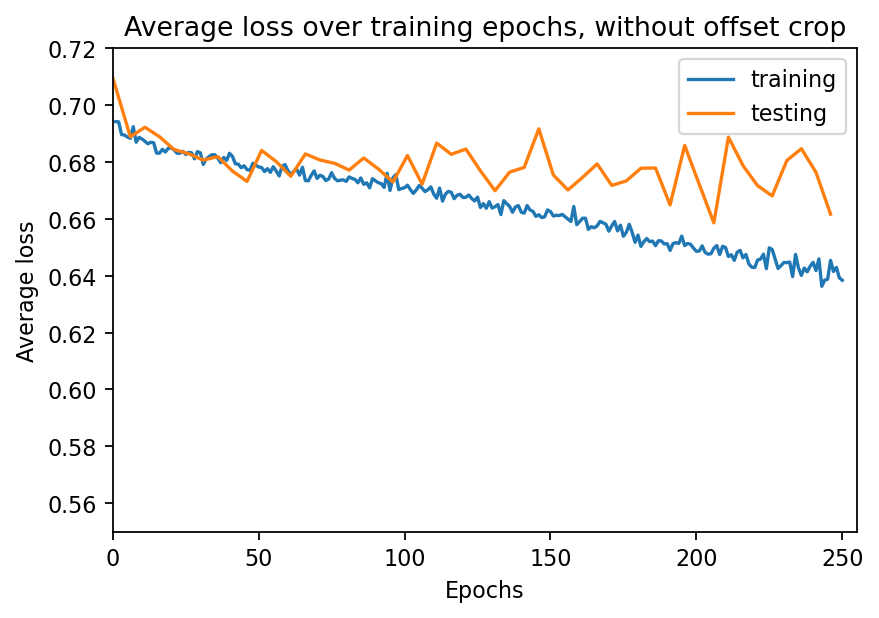

In [7]:
import matplotlib.pyplot as plt

plt.figure(dpi=160)
plt.xlabel("Epochs")
plt.ylabel("Average loss")
plt.ylim(0.55, 0.72)
plt.title("Average loss over training epochs, without offset crop")
plt.xlim(0, len(epoch_loss) + 5)
epochs_val = [0] + list(range(1, len(epoch_loss), 5))
plt.plot(list(range(1, len(epoch_loss) + 1)), [r / (len(batches_data) * batch_size) for r in epoch_loss], label="training")
plt.plot(epochs_val, [row[-1] for row in test_res], label="testing")
plt.legend()

plt.savefig("res/plots/train_test_loss_nocut")

In [9]:

print("Testing")
print("Creating batches.")
np.random.shuffle(stars)

batches_data = [np.zeros((batch_size, 1, 2000, 7, 7))]
batches_class = [np.zeros((batch_size))]

#Create batches
counter = 0
for i in range(len(stars) // 8 * 8):
    row = stars[i]
    if not row[3]:
        #Set random parts of data to 0
        l0 = math.floor(random.random() * 500)
        p0 = math.floor(random.random() * 2000)
        c = np.copy(row[2])
        for i in range(max(p0 - l0, 0), min(p0 + l0, 2000)):
            c[i][:] = -1
        batches_data[-1][counter] = c
        batches_class[-1][counter] = row[1]
        counter += 1

    if counter == batch_size:
        batches_data.append(np.empty((batch_size, 1, 2000, 7, 7)))
        batches_class.append(np.empty((batch_size)))
        counter = 0
print("Testing", len(batches_data), "batches.")
torch.cuda.empty_cache()
with torch.no_grad():
    total_loss = 0
    total_correct = 0
    for i in range(len(batches_data)):
        d = torch.from_numpy(batches_data[i]).to(device)
        c = torch.from_numpy(batches_class[i]).long().to(device)
        #Clear gradients
        opt.zero_grad()

        #Train
        p = classifier(d.float())
        
        #Find accuracy
        p2 = torch.argmax(p, dim=1)
        total_correct += len([i for i in range(len(p2)) if p2[i] == c[i]])
        
        #Calculate loss and store
        l = loss(p, c)
        total_loss += l.item() * batch_size
        
        del d
        del c

    print("Total Loss:", total_loss, "\n")
    epoch_loss.append(total_loss)
print("Total Correct:", total_correct, "/", len(batches_data) * batch_size, "(" + str(total_correct / (len(batches_data) * batch_size)) + ")")

Testing
Creating batches.
Testing 6 batches.
Total Loss: 200.77975273132324 

Total Correct: 158 / 288 (0.5486111111111112)


In [8]:
torch.save(classifier.state_dict(), "cache/new_model_1.pt")

In [20]:
import matplotlib.pyplot as plt
from torchvision import utils

def visualize_tensor(tensor, ch=0, allkernels=False, nrow=8, padding=1, layer=0): 
    n,c,d,w,h = tensor.shape

    if allkernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    
    tensor = torch.stack([tensor[layer, :, i, :, :] for i in range(7)])
    tensor = tensor.to(torch.device("cpu"))
    print(tensor.shape, tensor.device)
    
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
layer = 4
f = classifier.c3d[0][0].weight.data.clone()
visualize_tensor(f, ch=0, allkernels=False, layer=layer)

plt.axis('off')
plt.ioff()
plt.show()

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [12]:
model.save_res()